In [267]:
import imageio
import matplotlib.animation as ani
import matplotlib.cm as cmx
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from matplotlib.patches import Ellipse
from PIL import Image
from sklearn import datasets
from sklearn.cluster import KMeans
from scipy.stats import multivariate_normal

In [268]:
data = pd.read_csv("data2D.txt")
Y = data.to_numpy()
print(Y)
print(Y.shape)

X = []
for i in range(len(Y)):
    data_point = Y[i][0].rstrip("'").lstrip("'").split(" ")
    for j in range(len(data_point)):
        data_point[j] = float(data_point[j])
    X.append(data_point)
X = np.array(X)

bias_matrix = np.diag(np.full(X.shape[1], 0.00000011))
fig = plt.figure(figsize=(7,7), num=1) 

[['3.809500 0.798500']
 ['-1.661400 -0.577700']
 ['-0.257300 -0.155600']
 ...
 ['1.192000 2.247500']
 ['0.455500 0.884600']
 ['0.272500 0.951600']]
(1499, 1)


<Figure size 700x700 with 0 Axes>

In [269]:
def visualization(X, clusters, fig):
    ax0 = fig.add_subplot(111)
    ax0.scatter(X[:,0], X[:,1], linewidths=0.001)
    ax0.set_title("GMM-EM")
    
    x, y = np.mgrid[np.min(X[:, 0]):np.max(X[:, 0]):.01, np.min(X[:, 1]):np.max(X[:, 1]):.01]
    positions = np.dstack((x, y))
    for i in range(len(clusters)):
        multi_normal = multivariate_normal(mean=clusters[i]['mu'],cov=clusters[i]['sigma'])
        
        ax0.contour(x, y, multi_normal.pdf(positions),colors='black',alpha=0.3)
        ax0.scatter(clusters[i]['mu'][0], clusters[i]['mu'][1] ,c='grey',zorder=10,s=100)

In [270]:
def animate(X, clusters):
    fig1 = plt.figure(num=1)
    ax0 = fig1.add_subplot(111)
    ax0.scatter(X[:,0], X[:,1], linewidths=0.001)
    
    x, y = np.mgrid[np.min(X[:, 0]):np.max(X[:, 0]):.01, np.min(X[:, 1]):np.max(X[:, 1]):.01]
    positions = np.dstack((x, y))
    for i in range(len(clusters)):
        multi_normal = multivariate_normal(mean=clusters[i]['mu'],cov=clusters[i]['sigma'])
        
        ax0.contour(x, y, multi_normal.pdf(positions),colors='black',alpha=0.3)
        ax0.scatter(clusters[i]['mu'][0], clusters[i]['mu'][1] ,c='grey',zorder=10,s=100)
        
    print("figure no. ", plt.gcf().number)
    plt.pause(0.005)
    fig1.clf()
    plt.show()
    

In [271]:
def initialize(X, no_clusters, isanimate, fig):
    clusters = []
    
    mu_k = np.random.rand(no_clusters, X.shape[1])
    for i in range(no_clusters):
        clusters.append({
            'mu': mu_k[i],
            'sigma': np.identity(X.shape[1]),
            'pi': 1 / no_clusters
        })
    if isanimate:
        visualization(X, clusters, fig)
    return clusters

In [272]:
def expectation(X, clusters):
    no_clusters = len(clusters)
    no_data_points = X.shape[0]
    gamma = np.zeros((no_data_points, no_clusters))
    
    for k in range(no_clusters):
        gamma[:, k] = clusters[k]['pi'] * multivariate_normal.pdf(X, clusters[k]['mu'], clusters[k]['sigma']).reshape(-1)
    gamma = (gamma.T / np.sum(gamma, axis=1)).T
    return gamma

In [273]:
def maximization(X, clusters, gamma, isanimate):
    no_clusters = len(clusters)
    no_data_points = X.shape[0]
    N_k = np.sum(gamma, axis=0)
    
    for k in range(no_clusters):
        clusters[k]['mu'] = (1 / N_k[k]) * np.sum(gamma[:, k] * X.T, axis=1).T
        clusters[k]['sigma'] = (1 / N_k[k]) * np.dot(((X - clusters[k]['mu']).T * gamma[:, k]), (X - clusters[k]['mu']))
        clusters[k]['sigma'] += bias_matrix
        clusters[k]['pi'] = N_k[k] / no_data_points
        if isanimate:
            animate(X, clusters)
    return clusters

In [274]:
def likelihood(X, clusters):
    no_clusters = len(clusters)
    no_data_points = X.shape[0]
    likelihood = 0
    
    for k in range(no_clusters):
        likelihood += clusters[k]['pi'] * multivariate_normal.pdf(X, clusters[k]['mu'], clusters[k]['sigma']).reshape(-1)
    return np.sum(np.log(likelihood))

In [275]:
def train(X, no_clusters, max_iter, isanimate, fig):
    clusters = initialize(X, no_clusters, isanimate, fig)
    
    plt.ion()
    for i in range(max_iter):
        gamma = expectation(X, clusters)
        clusters = maximization(X, clusters, gamma, isanimate)
        log_likelihood_current = likelihood(X, clusters)
        # print("epoch: ", i, "likelihood: ", log_likelihood_current)
        
        if i > 0 and np.abs(log_likelihood_current - log_likelihood) < 0.0001:
            break
        
        log_likelihood = log_likelihood_current
    plt.ioff()
    plt.show()   
    return clusters, log_likelihood

In [276]:
min_k = 1
max_k = 10
no_clusters = np.arange(min_k, max_k+1, 1)
max_iteration = 50


likelihood_for_clusters = []
for i in range(len(no_clusters)):
    clusters, log_likelihood = train(X, no_clusters[i], max_iteration, False, fig)
    print("no_clusters: ", no_clusters[i], "likelihood: ", log_likelihood)
    likelihood_for_clusters.append(log_likelihood)
    


no_clusters:  1 likelihood:  -5095.849070449309
no_clusters:  2 likelihood:  -4547.457698209899
no_clusters:  3 likelihood:  -3886.7191772532606
no_clusters:  4 likelihood:  -3884.8400479777133
no_clusters:  5 likelihood:  -3878.514164166262
no_clusters:  6 likelihood:  -3876.9297663260268
no_clusters:  7 likelihood:  -3876.078539735717
no_clusters:  8 likelihood:  -3869.896941071159
no_clusters:  9 likelihood:  -3874.0073465984724
no_clusters:  10 likelihood:  -3867.743009454465


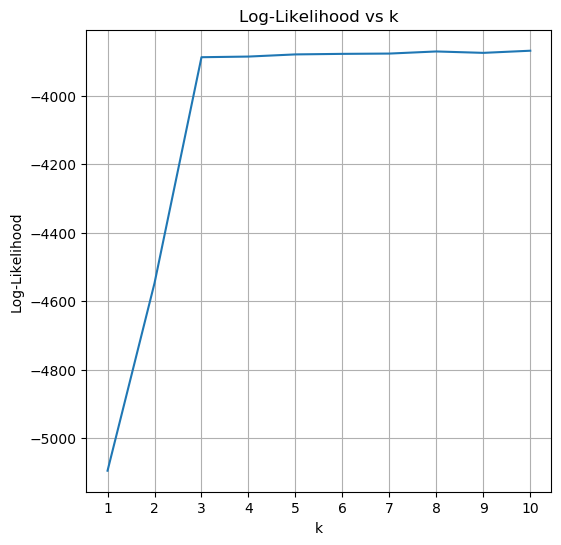

In [277]:
plt.figure(figsize=(6, 6))
plt.title('Log-Likelihood vs k')
plt.plot(no_clusters, likelihood_for_clusters)
plt.xlabel('k')
plt.ylabel('Log-Likelihood')
plt.grid()
plt.xticks(np.arange(min_k, max_k+1, 1))
plt.show()

In [278]:
#Calculate the k*
for i in range(len(likelihood_for_clusters)-1):
    diff = abs(likelihood_for_clusters[i+1] - likelihood_for_clusters[i])
    diff_percentage = abs(diff / likelihood_for_clusters[i])
    if diff_percentage < 0.01:
        k_star = no_clusters[i]
        break
print("k* = ", k_star)

k* =  3


figure no.  1


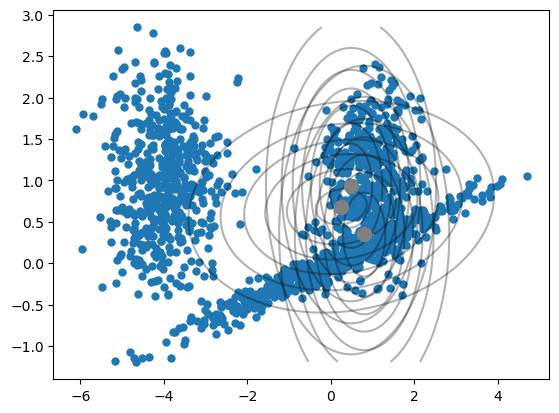

figure no.  1


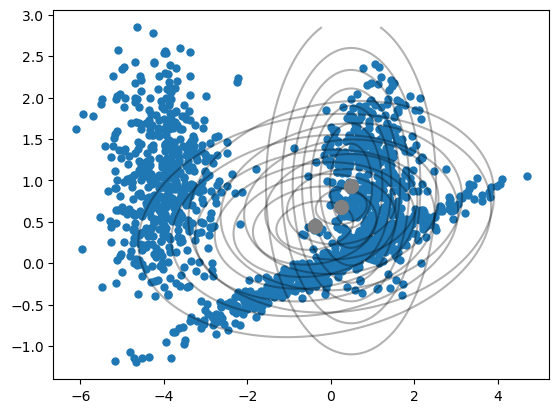

figure no.  1


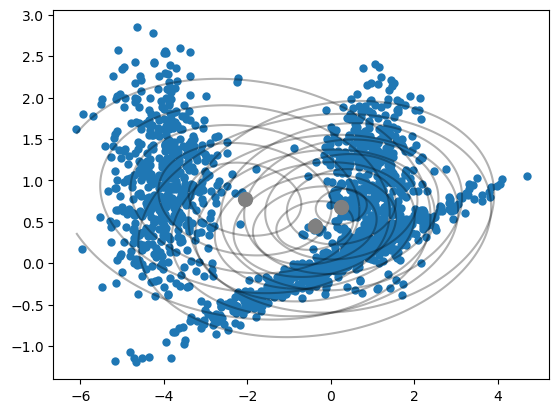

figure no.  1


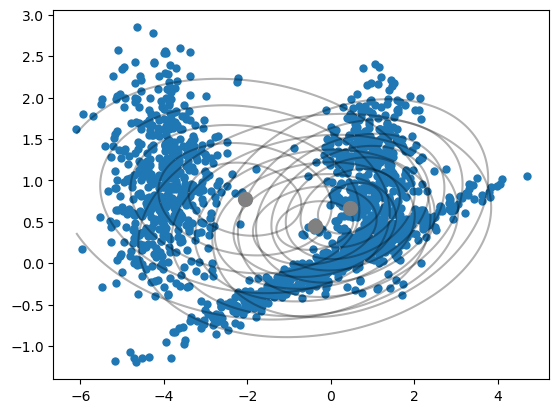

figure no.  1


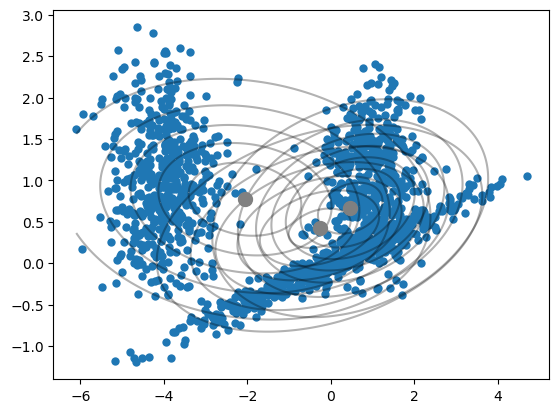

figure no.  1


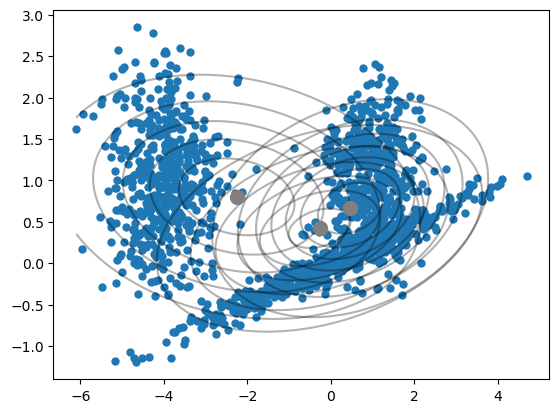

figure no.  1


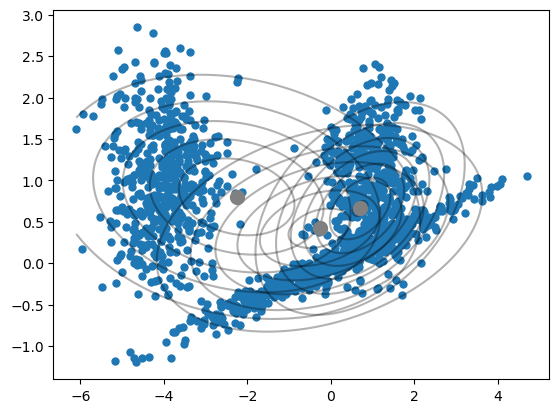

figure no.  1


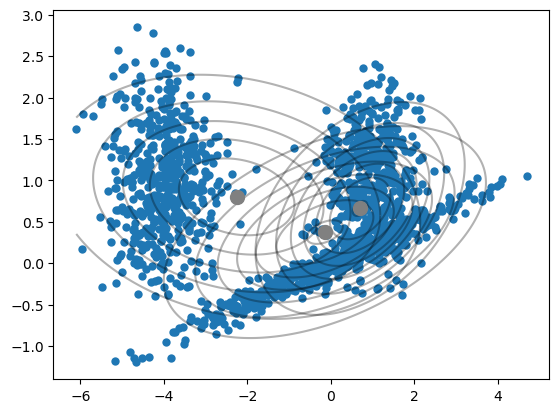

figure no.  1


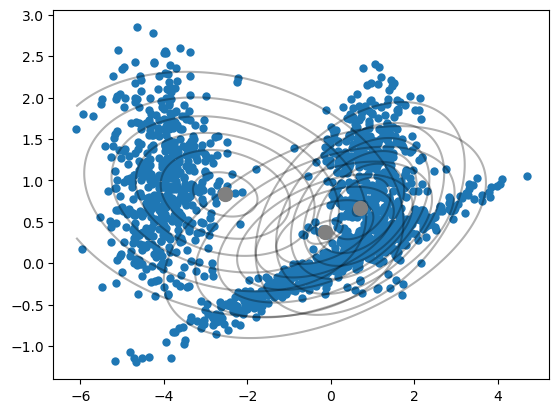

figure no.  1


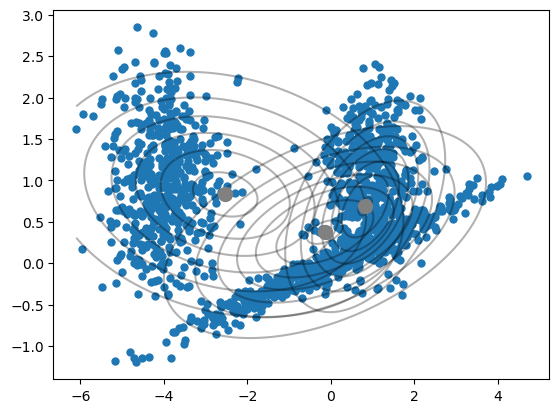

figure no.  1


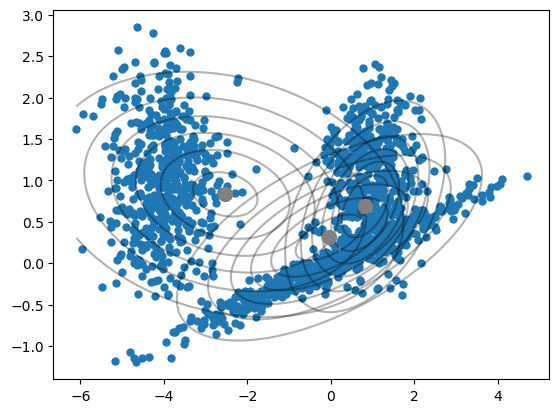

figure no.  1


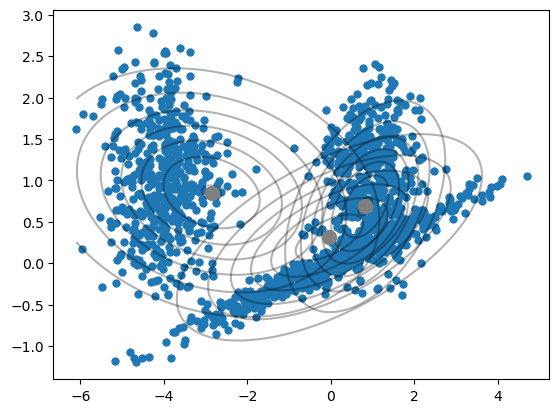

figure no.  1


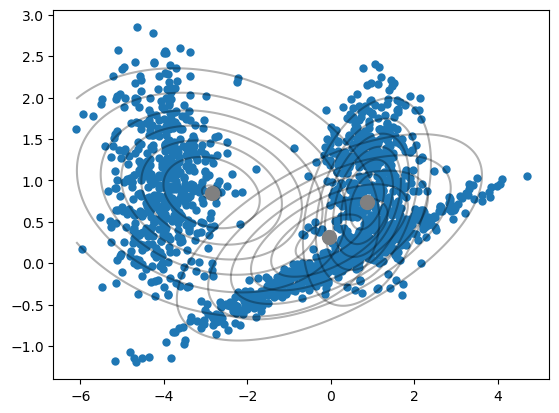

figure no.  1


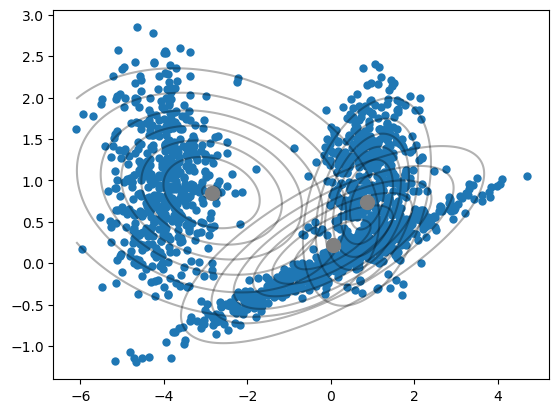

figure no.  1


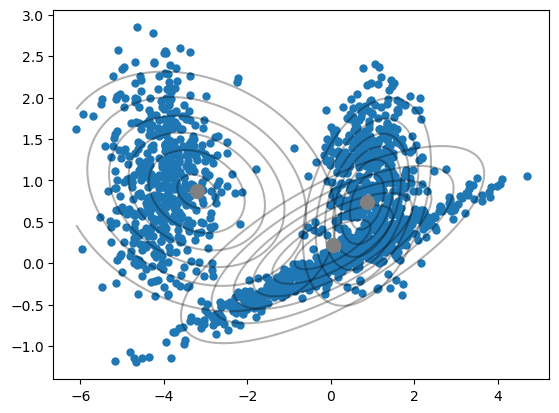

figure no.  1


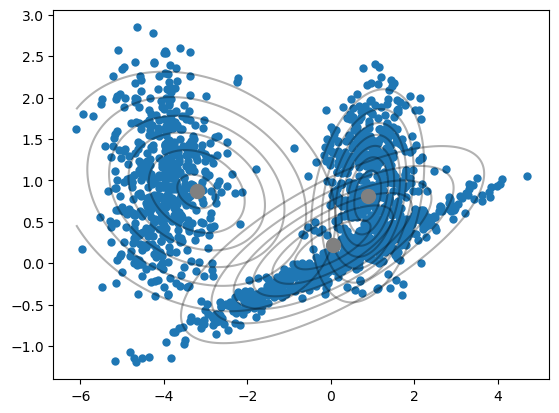

figure no.  1


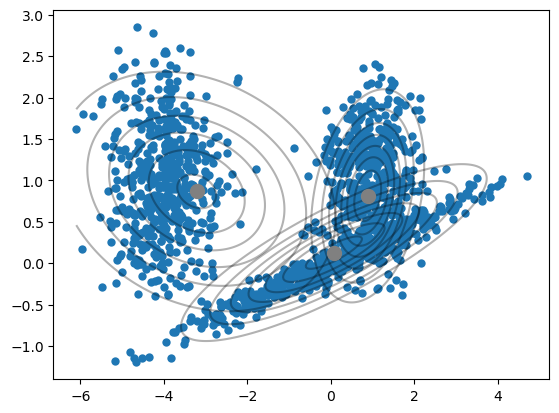

figure no.  1


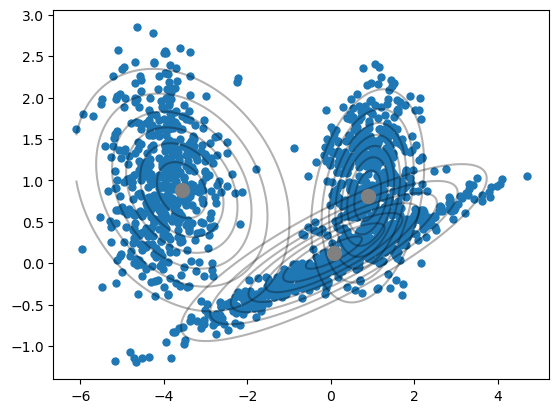

figure no.  1


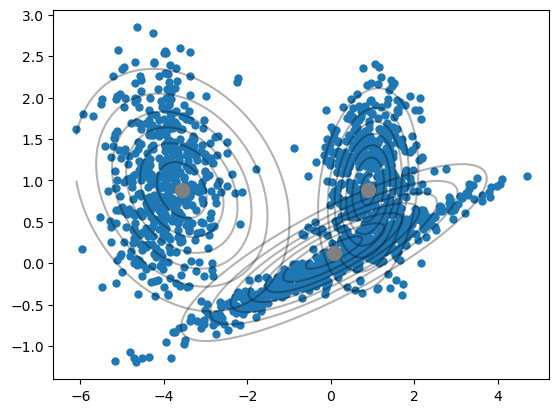

figure no.  1


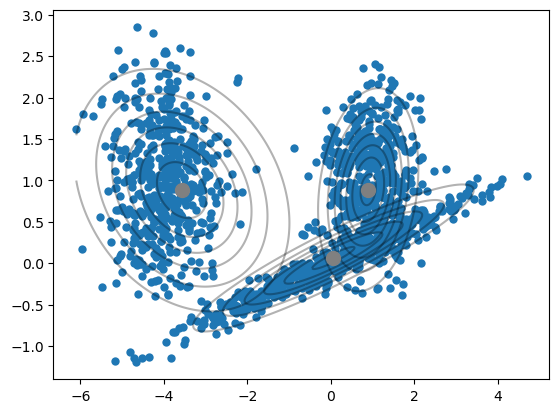

figure no.  1


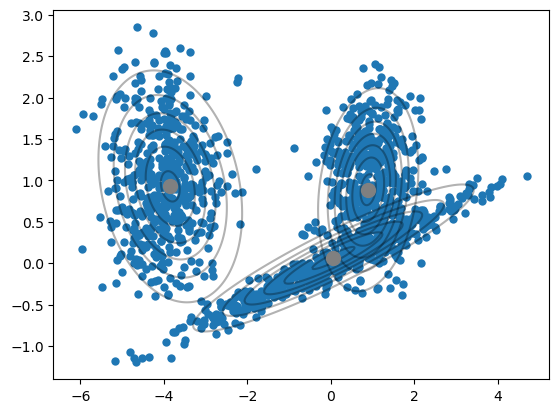

figure no.  1


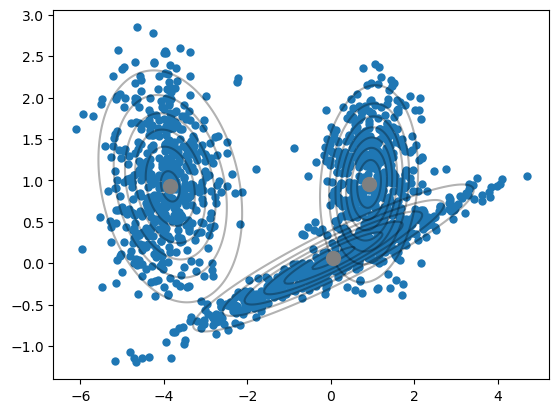

figure no.  1


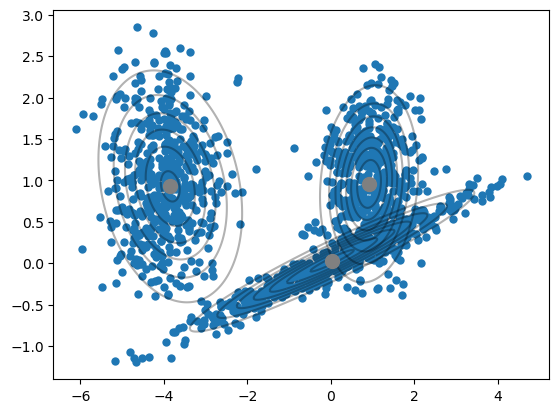

figure no.  1


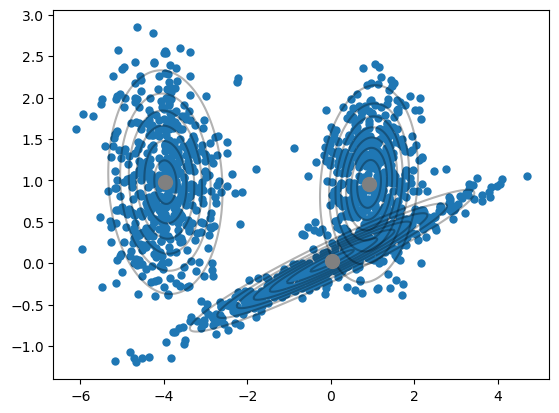

figure no.  1


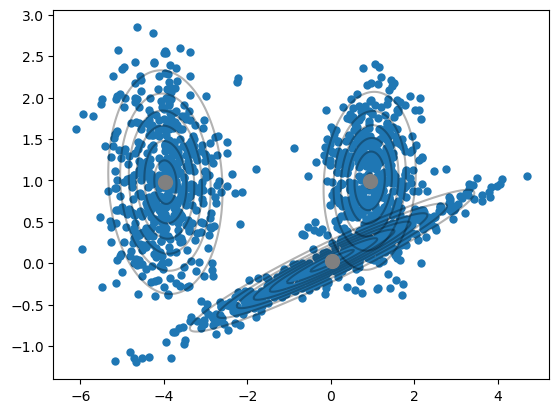

figure no.  1


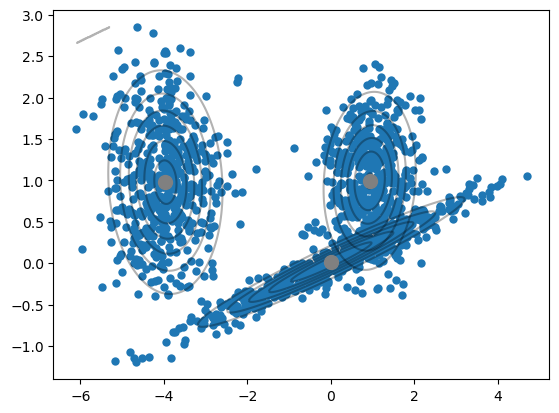

figure no.  1


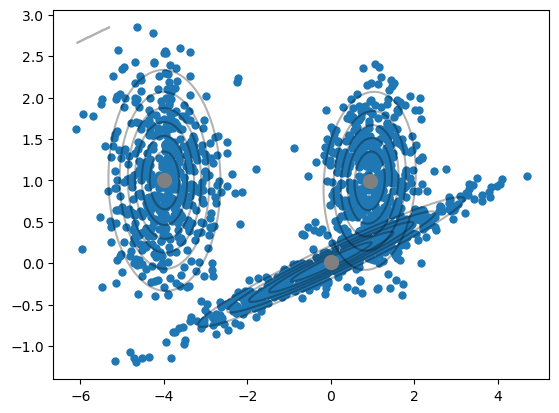

figure no.  1


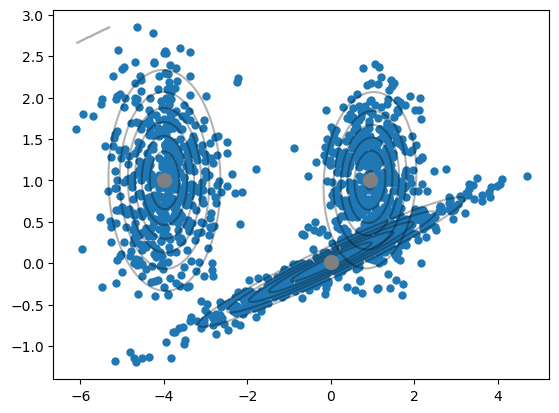

figure no.  1


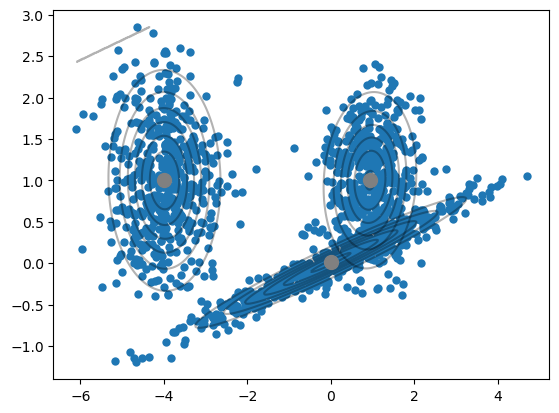

figure no.  1


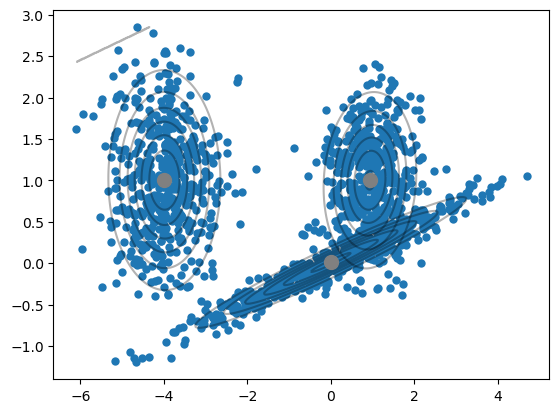

figure no.  1


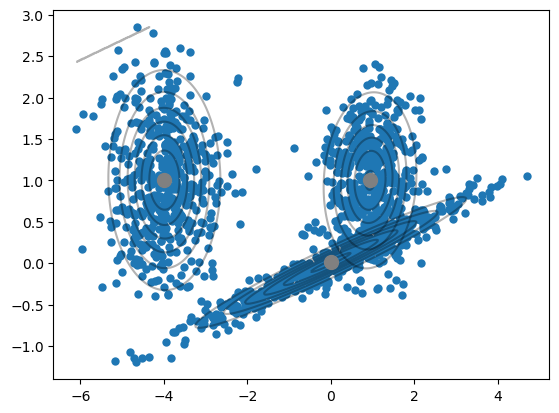

figure no.  1


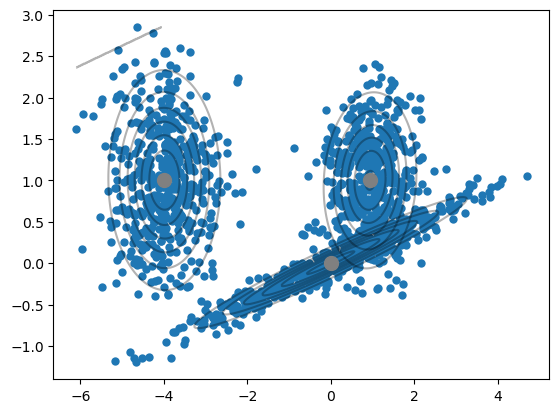

figure no.  1


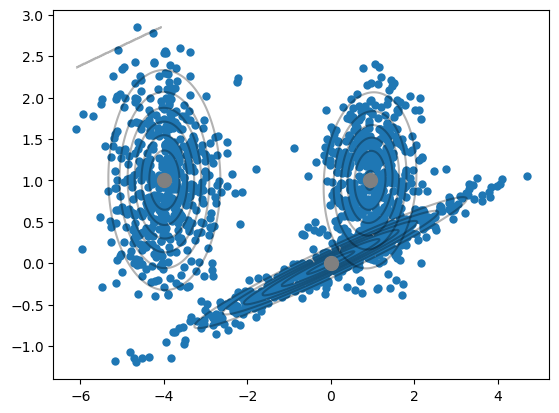

figure no.  1


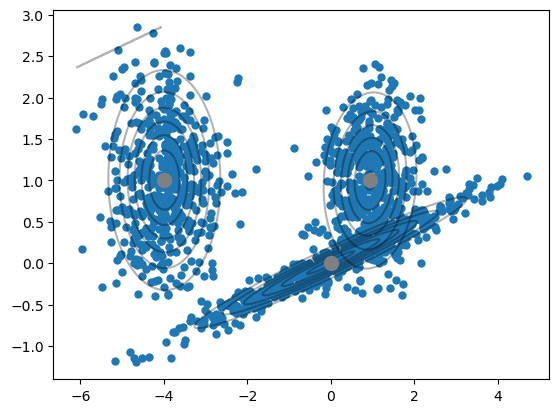

figure no.  1


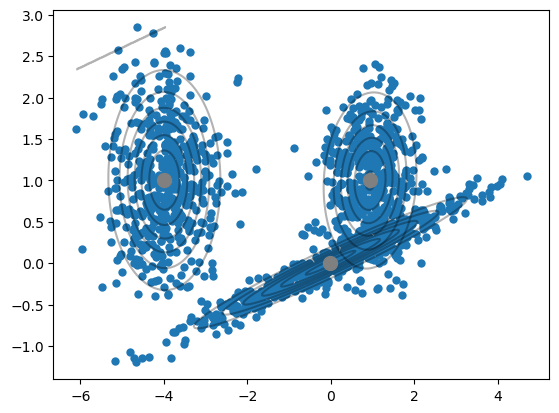

figure no.  1


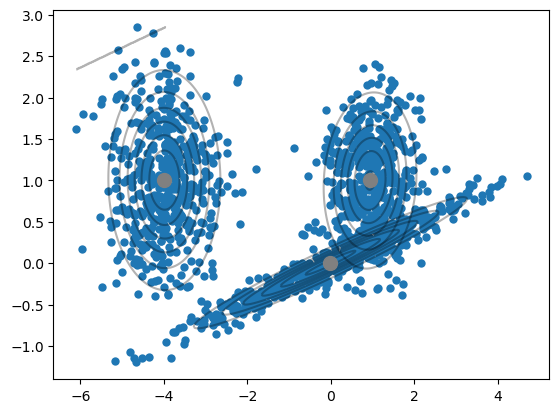

figure no.  1


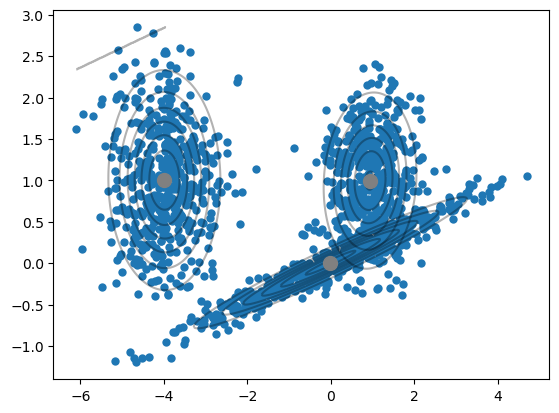

figure no.  1


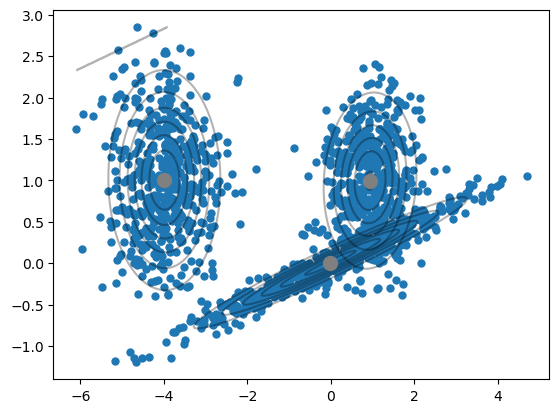

figure no.  1


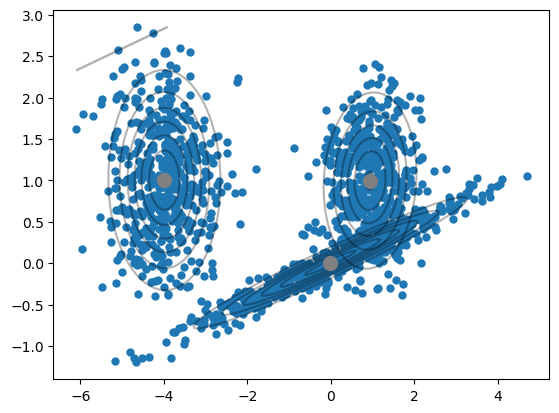

figure no.  1


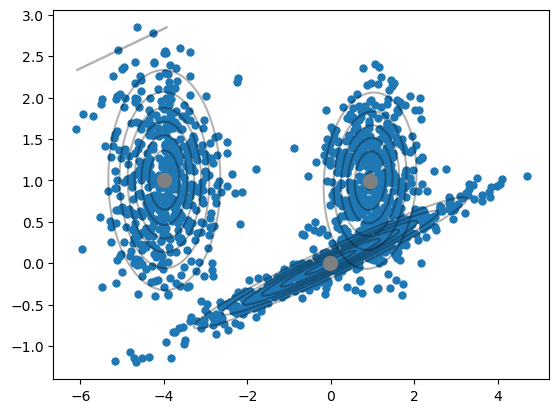

figure no.  1


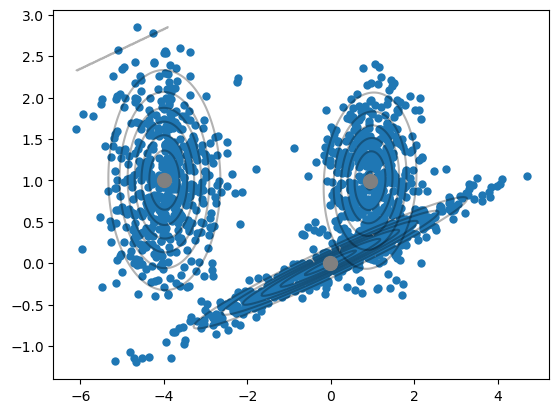

figure no.  1


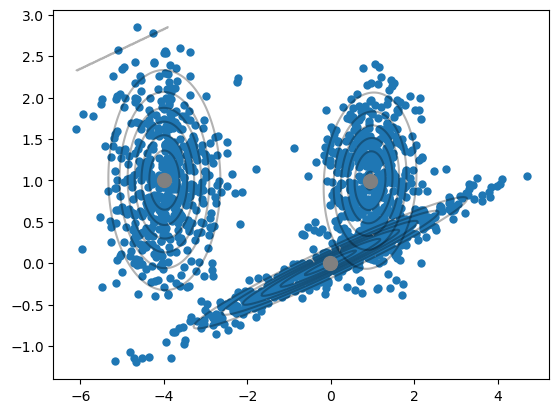

figure no.  1


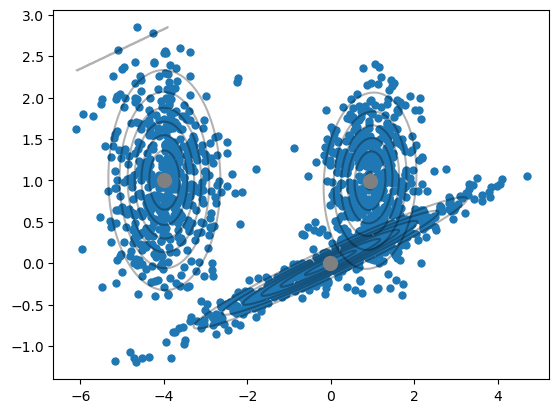

figure no.  1


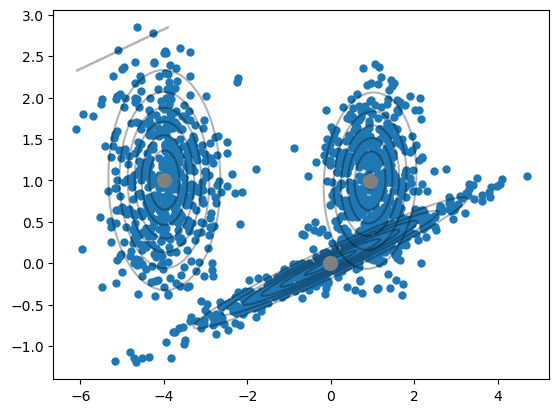

figure no.  1


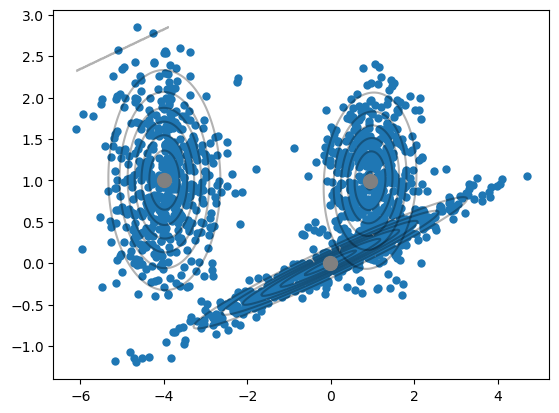

figure no.  1


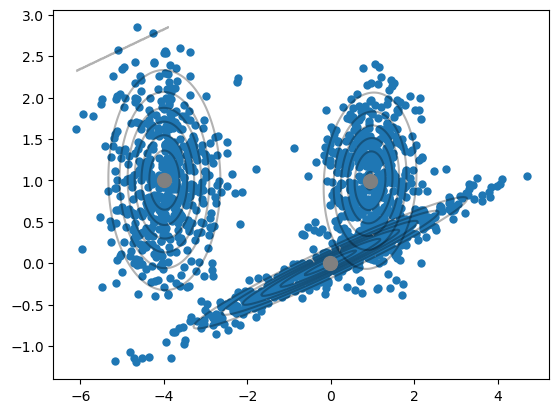

figure no.  1


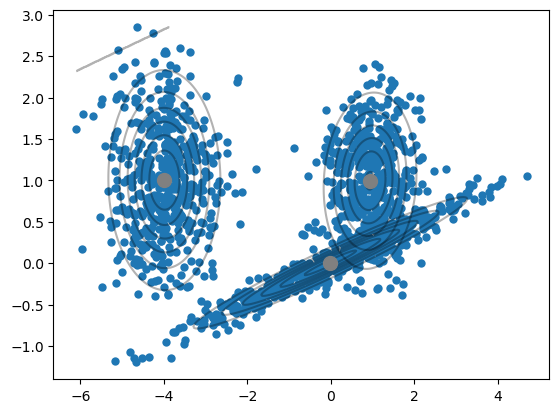

figure no.  1


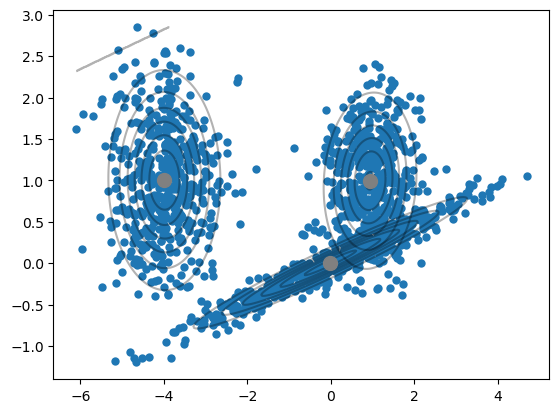

figure no.  1


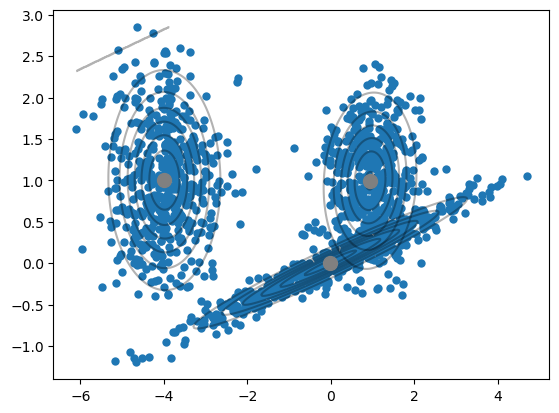

figure no.  1


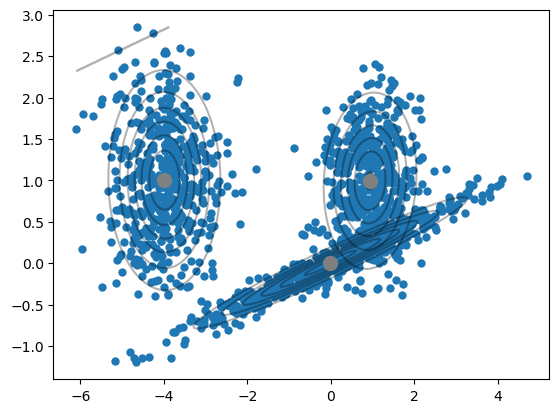

figure no.  1


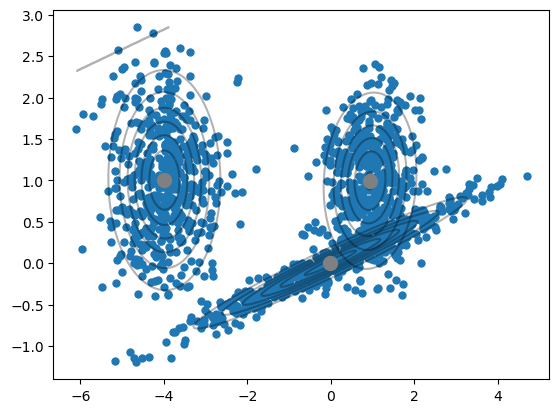

In [279]:
clusters, log_likelihood = train(X, k_star, max_iteration, True, fig)